# Room Acoustic Measurment

## Background

This is a prototype program that will be able to run testing on your room accoustic. All you need to do is perform a few recordings, those being the following:
1. Recording of an impulse response (WAV of IR is provided below)
2. Recording of a sine sweep (WAV of sweep also provided)

These recordings must be done in a 24-bit, 44.1kHZ, .wav format (Single channel is fine atm). Positionally the microphone should be in the position you listen from at ear position height. To perform test recordings must have minimal background noise. Run your wave files through the "floorNoiseCheck" function before performing any other tasks. This will give you a boolean and a leaking background noise measurment result.

Kinds of measurments

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display as ld
from IPython.display import Audio 
import scipy.signal as sc
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

## Dependencies

In [2]:
def linearFit(x,m,b):
    return m*x+b

In [3]:
def schroedersIntegral(signal):
    """
    This function implements M.R. Schroeders reverb time integral. This method modernizes
    the constant need of averaging over many reverb curve collections. This methods uses
    the cumulative sum.
    
    params
    ------
    signal

    returns
    -------
    sch: the M.R. Schroeder reverb time integral 
    """


    cumsum = np.zeros(len(signal),dtype=type(signal[0]))
    #signal cumsum
    for i in range(0,len(signal)):
        if i == 0:
            cumsum[i] = signal[i]
        else:
            cumsum[i] = signal[i] + cumsum[i-1]
    
        
    sch = 10.0 * np.log10((cumsum)[::-1] 
                           / np.max(cumsum))
    return sch


In [4]:
def movingAvg(x, k):
    """
    params
    ------
    x: data
    k: window size

    returns
    -------
    moving average
    """
    # Reflective padding
    pad_width = k // 2
    x_padded = np.pad(x, pad_width, mode='reflect')
    
    movAvg = []
    # Calculate moving average
    for i in range(len(x)):
        frame = x_padded[i:i+k]
        frameAvg = np.mean(frame)
        movAvg.append(frameAvg)
    
    return np.array(movAvg, dtype='float32')

## Acoustic Measurment

In [78]:
def reverbTimeCalc(signalChunk, buffer, fs, integralSize):
    reverbTimeArr = []
    buffer = np.append(buffer,signalChunk)

    if(len(buffer) >= 19900):

        t = np.arange(len(buffer)) / fs;
    
        xAnyl = sc.hilbert(buffer);
        xEnvelope = np.abs(xAnyl);
        xMA = movingAvg(xEnvelope,90);

        xSch = schroedersIntegral(xMA[:integralSize][::-1]**2);

        popt,pconv = curve_fit(linearFit,t[:integralSize],xSch[:integralSize])
        m,b = popt    
        y = m * t + b
        reverbTimeArr = [-60/m,-30/m,-20/m,-10/m]

        plt.figure(figsize = (20,8))
        plt.plot(t,buffer,'b',label = "Signal")
        plt.plot(t,xEnvelope,'r',label = "Analytical Signal: no phase info")
        plt.xlim(0,0.04)
        plt.legend()

        plt.figure(figsize = (20,8))
        plt.plot(t,20*np.log10(xMA),'r',linewidth=3.5,label="Avg Signal")
    
        plt.figure(figsize = (20,8))
        plt.plot(t,20*np.log10(buffer),'b',label='Audio Signal')
        plt.plot(t[:integralSize],xSch[:integralSize],'xkcd:spearmint',linewidth=3.5,label = "Schroders Integral Curve")
        #plt.plot(t[:2*N],y[:2*N],color="tab:orange",ls="dotted",linewidth = 3.5,label = "Curve Fit")
        plt.legend()



       
    return reverbTimeArr, buffer
    



In [37]:
# def reverbTimeCalc(signalChunk, fs, buffer, N):
#     """
#     reverbTimeCalc will determin the reverberation time at RT60,30,20,and 10 for a given impulse respnse.

#     Params
#     -------
#     signal: [ndarray] time-series impulse response .wav
    
#     fs: [int] sampling rate 
    
    
#     N/integration_size:[int] select amount of samples needed to integrate. 
#     You dont wnat to integeate the entire power spectrome; only the dip. 
#     To-do: find a way to automate this process. 

#     Returns
#     -------
#     reverbTimeArr: [ndarray] An array containing the reverb time calculations. In C++
#     this is a struct
    
#     """

#     buffer = np.append(buffer,signalChunk)
#     #time array
#     t = np.arange(len(buffer))/fs

#     #Analytical signal removes any phase information
#     x_anyl = sc.hilbert(buffer)
#     x_env = np.abs(x_anyl)
#     x_log = 20.0*np.log10(x_env) 
#     x_ma = movingAvg(x_log,90)
#     #x_ma = movingAvg(x_ma,30)
#     #x_ma = movingAvg(x_ma,30)

#     #Filter the signal to remove noise
#     # ma_filter = np.ones(window_size) / window_size
#     # x_ma = np.convolve(x_env, ma_filter, mode='same') 
    
#     # x_ma1 = x_ma[:N]

#     #sch = 10.0 * np.log10(np.cumsum(x_ma1[::-1]**2)[::-1] / np.max(np.cumsum(x_ma1[::-1]**2))
#     #N = 7000
#     sch = schroedersIntegral(x_ma[:N][::-1]**2)
    
    
#     ##ANALYSIS
#     popt,pconv = curve_fit(linearFit,t[:N],sch)
#     m,b = popt    
#     y = m * t + b
#     reverbTimeArr = [-60/m,-30/m,-20/m,-10/m]

#     # plt.figure(figsize = (20,8))
#     # plt.plot(t,signal,'b',label = "Signal")
#     # plt.plot(t,x_env,'r',label = "Analytical Signal: no phase info")
#     # plt.xlim(0,0.04)
#     # plt.legend()

#     # plt.figure(figsize = (20,8))
#     # plt.plot(t,20*np.log10(x_ma),'r',linewidth=3.5,label="Avg Signal")

#     # plt.figure(figsize = (20,8))
#     # plt.plot(t,20*np.log10(signal),'b',label='Audio Signal')
#     # plt.plot(t[:N],sch,'xkcd:spearmint',linewidth=3.5,label = "Schroders Integral Curve")
#     # plt.plot(t[:2*N],y[:2*N],color="tab:orange",ls="dotted",linewidth = 3.5,label = "Curve Fit")
#     # plt.legend()
    
#     return reverbTimeArr, buffer



In [6]:
def freqResponse(signal, ):
    sigFFT = np.fft.rfft(signal)
    pwrSpec = 10*np.log10(sigFFT)
    
    
    
    
    

In [7]:
def snrAnyl(signal, fs,  frame_length,  overlap, window_type):
    """
    SNR Analyzer. Will determine the snr levels of your room, ie: ratio between floor noise and direct signal
    
    signal: time-series audio vector
    fs: sampling rate 
    frame_length: number of samples to be processed per frame
    window_type: boxcar, triangle, hann, hamming, etc. 
    overlap: amount of overlapped windows
    """
    if (overlap == 0):
        step = 1;
        numWindows = np.ceil(len(signal)/frame_length);
    else:
        step = int(np.round(overlap*frame_length));
        numWindows = np.ceil(len(signal)/(overlap*frame_length));

    result = np.zeros(int(numWindows))
    k=0
    for i in range(0,len(signal),step):
        st = i
        en = min(frame_length + i, len(signal))
        
        #If end index - start index is less thatn window length - step break
        if (en - st < frame_length - step):
            break
        
        window = sc.windows.get_window(window_type, frame_length);
        #Window/Filter signal 
        windowedSig = sc.convolve(signal[st:en],window)

        segFFT = np.fft.rfft(windowedSig)
        segFFT[0] = 0 ## Remove DC offset
        
        
        result[k] = np.mean(np.abs(segFFT))

        

        k += 1   
    freqs = np.fft.rfftfreq(len(windowedSig), 1 / fs) 
    plt.figure(1)    
    plt.plot(freqs,result)

## Testing

/var/folders/mq/2x3nqx1s3m7_d6yf0m5rddsw0000gn/T/ipykernel_13014/160125226.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(t,20*np.log10(buffer),'b',label='Audio Signal')
/var/folders/mq/2x3nqx1s3m7_d6yf0m5rddsw0000gn/T/ipykernel_13014/160125226.py:30: RuntimeWarning: invalid value encountered in log10
  plt.plot(t,20*np.log10(buffer),'b',label='Audio Signal')


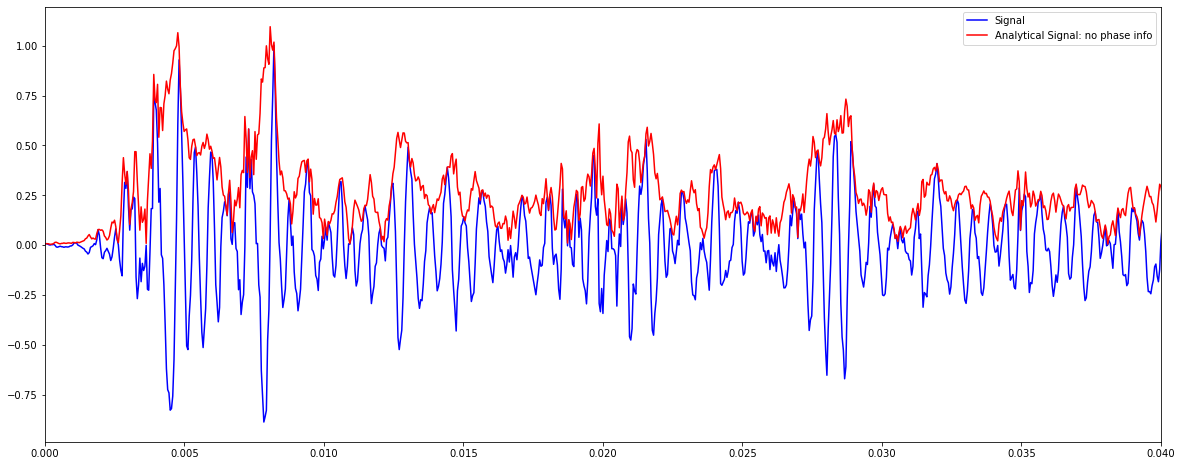

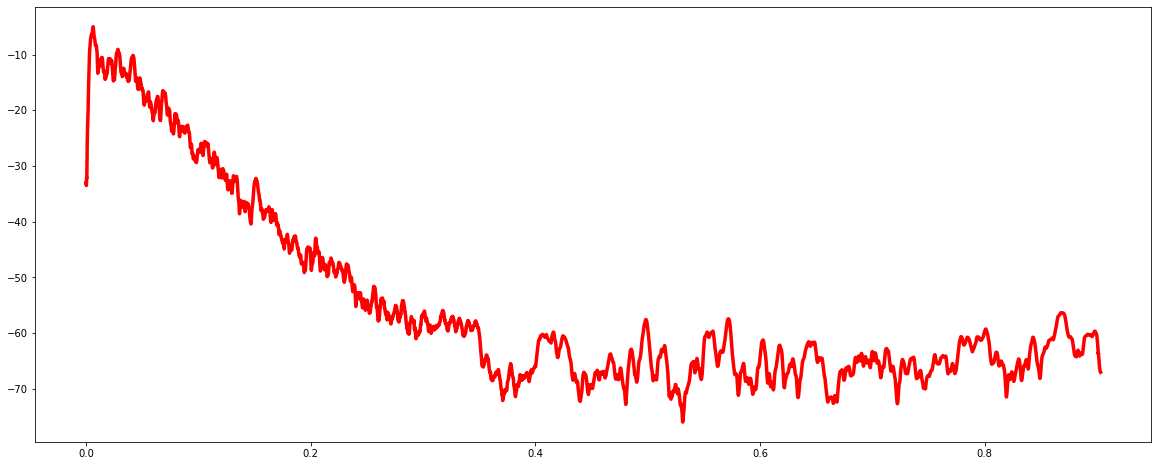

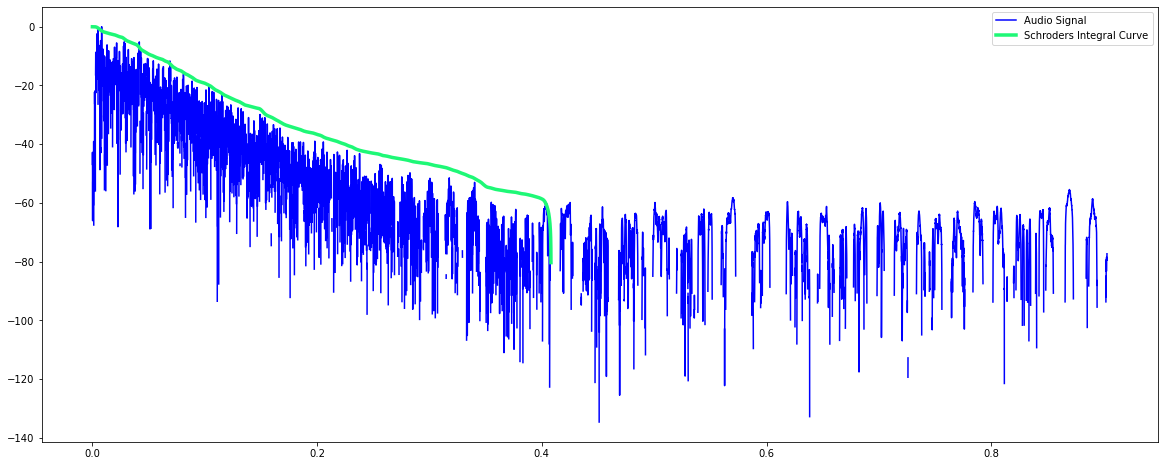

In [80]:
np.set_printoptions(threshold=None, edgeitems=None, linewidth=None, suppress=None)
#Test Signal
y,sr = lr.load("../wavs/bedroom_RIR.wav")

#snrAnyl(noiz,sr, 1024, 0.5, "hann")
#reverbTimeCalc(y,sr,128,7000)


"""
For sake of simulating a real time task, I read in the entire file to get the size
and time array but will be breaking up into chunks of 1024.
"""

x = np.array([])
tF = np.array([])
buffer = np.array([])
chunkSize = 1024
t = np.arange(len(y))/sr


for i in range(0,len(y),chunkSize):
    st = i
    en = i+chunkSize

    sigChunk = y[st:en]
    tChunk = t[st:en]
    
    # x_anyl = sc.hilbert(sigChunk)
    # x_env = np.abs(x_anyl)
    # x_ma = movingAvg(x_env,100)
    # avg = np.mean(x_ma)

    revTime, buffer = reverbTimeCalc(sigChunk,buffer,sr, 9000)
    
#xSch = schroedersIntegral(x[::-1]**2)


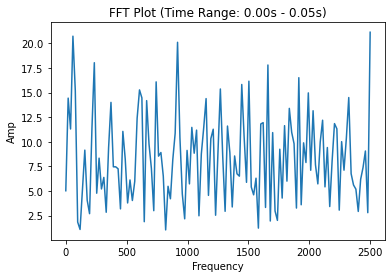

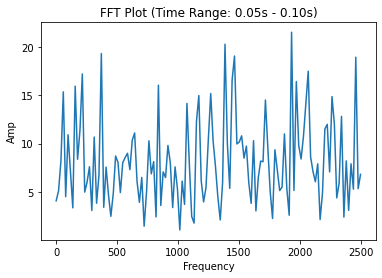

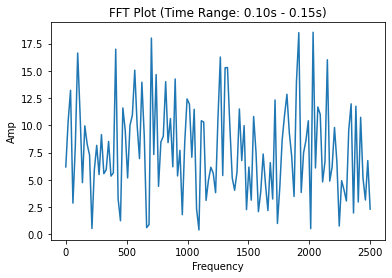

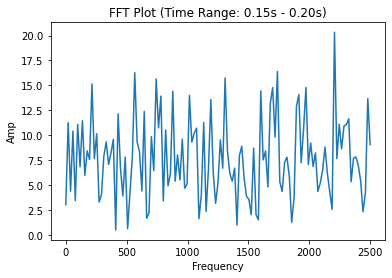

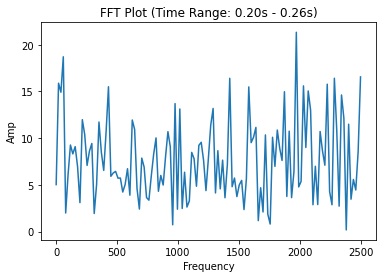

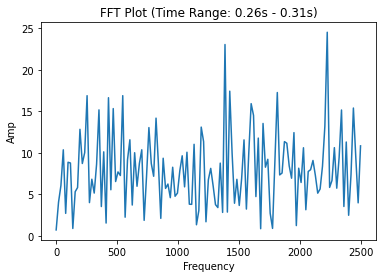

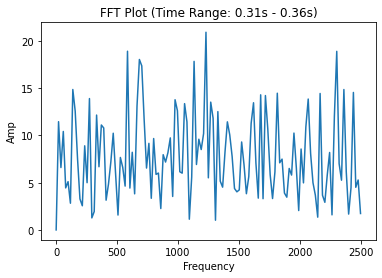

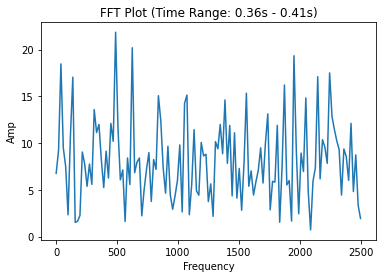

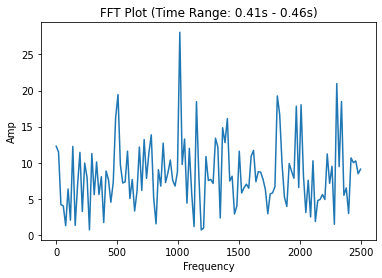

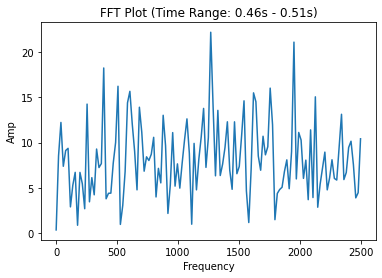

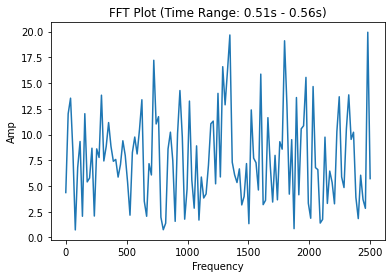

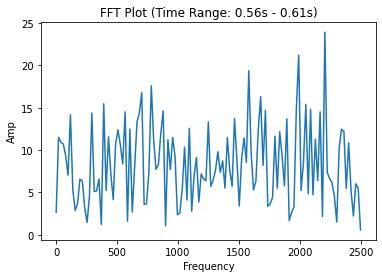

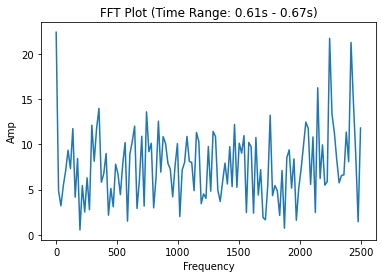

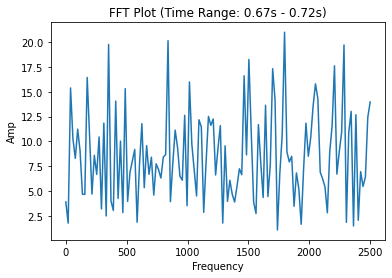

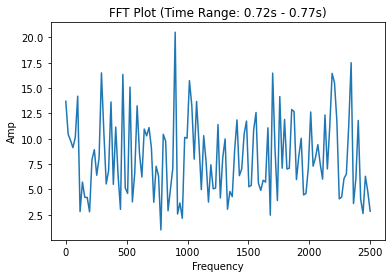

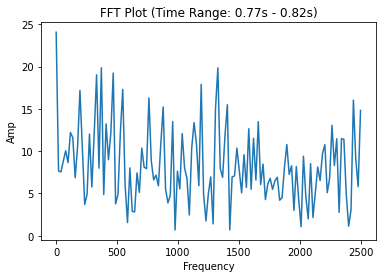

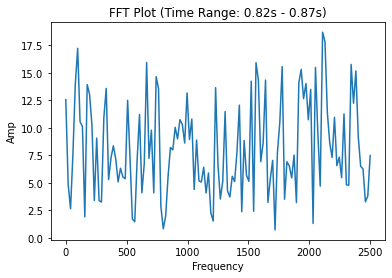

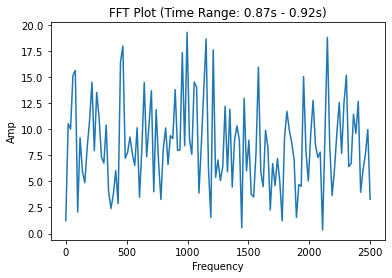

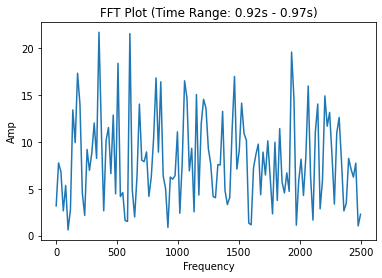

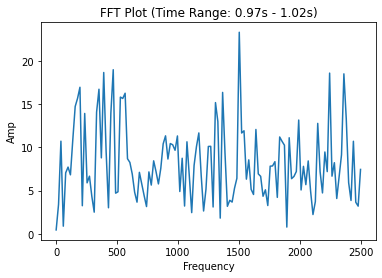

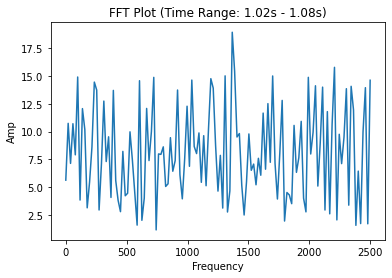

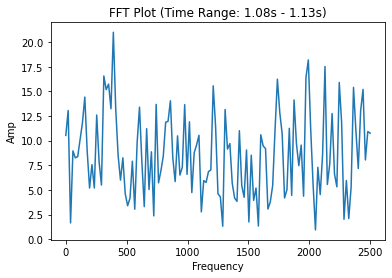

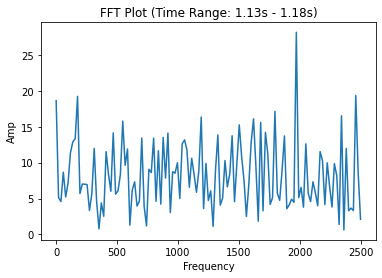

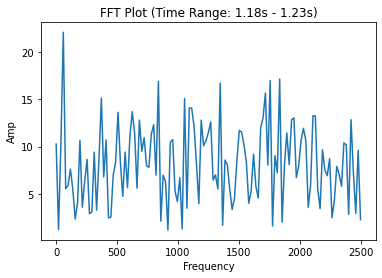

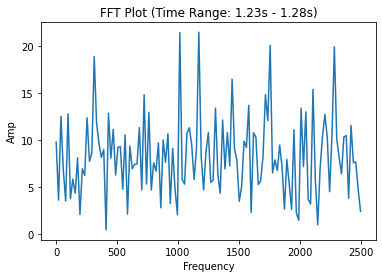

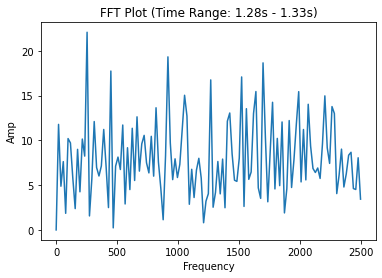

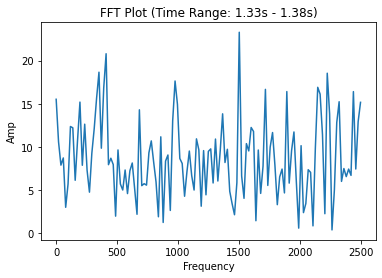

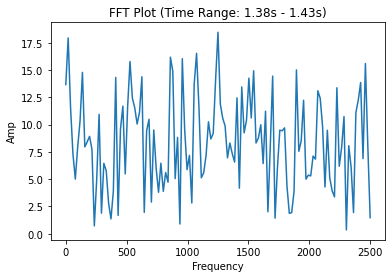

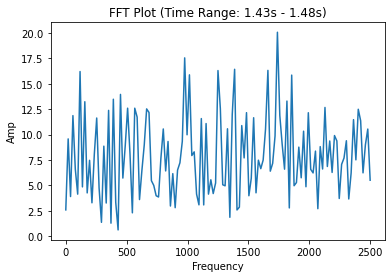

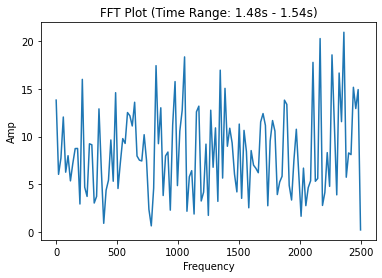

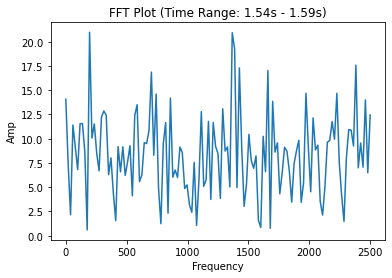

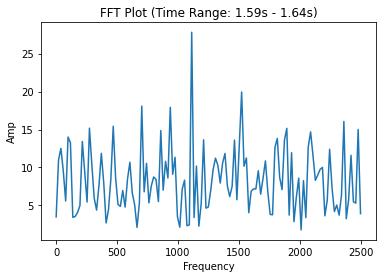

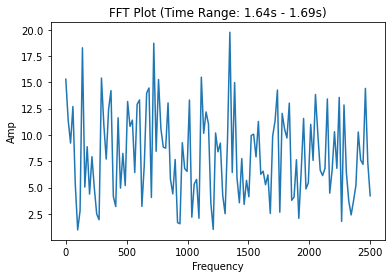

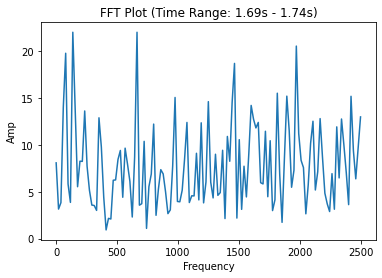

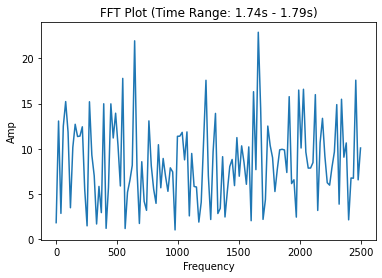

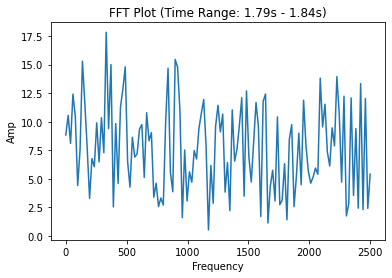

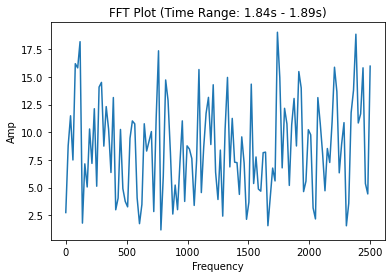

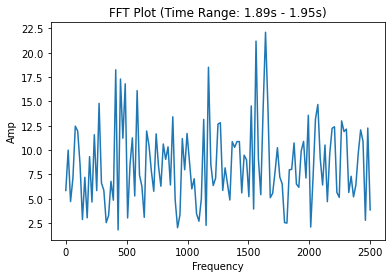

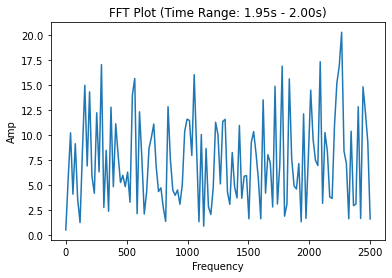

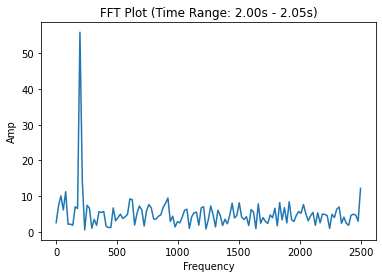

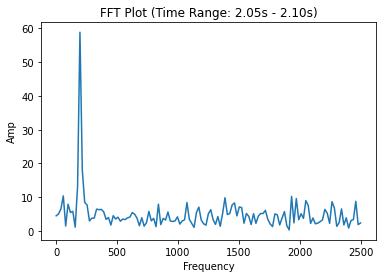

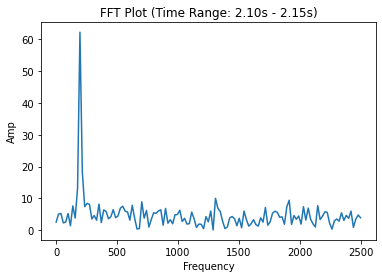

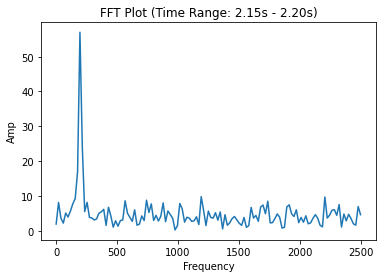

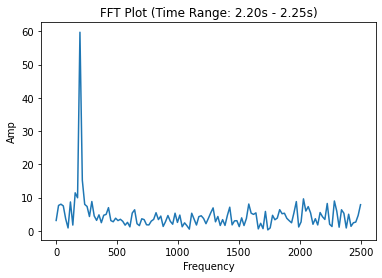

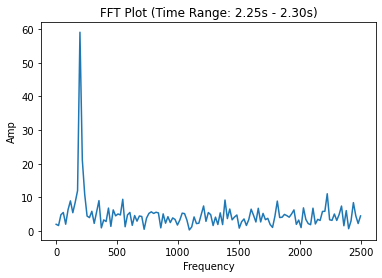

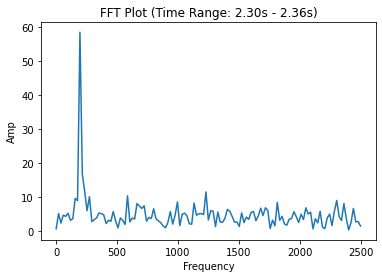

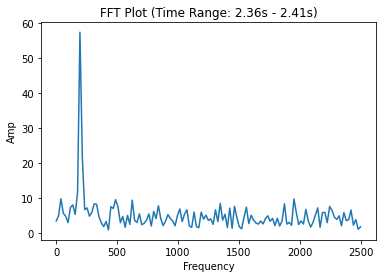

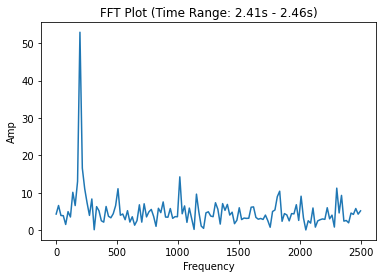

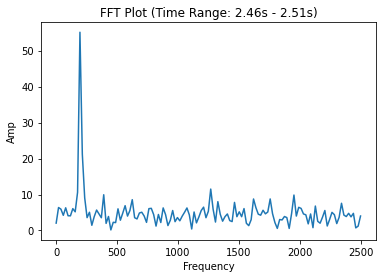

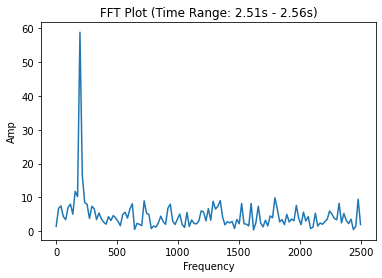

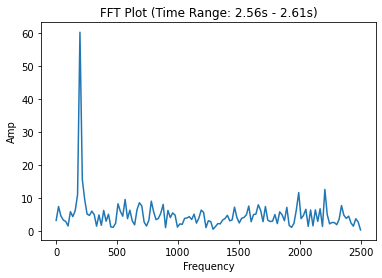

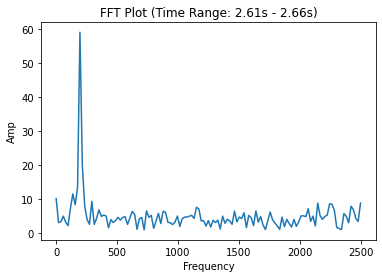

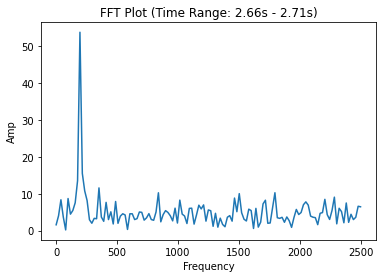

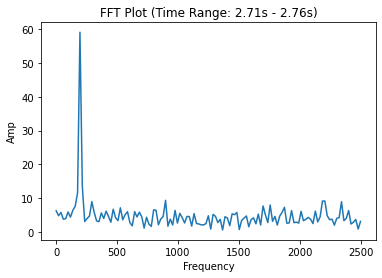

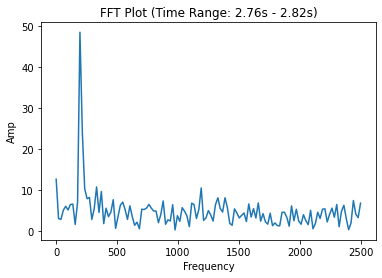

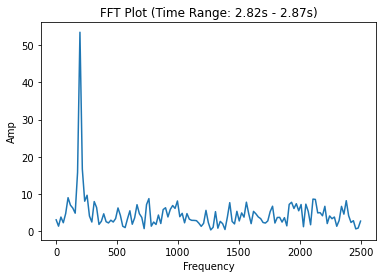

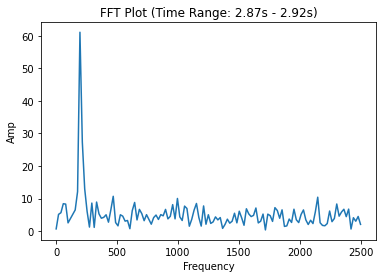

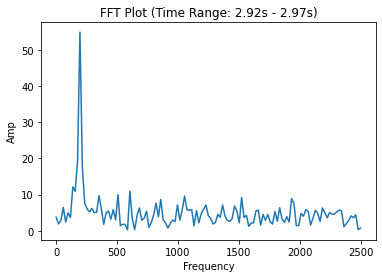

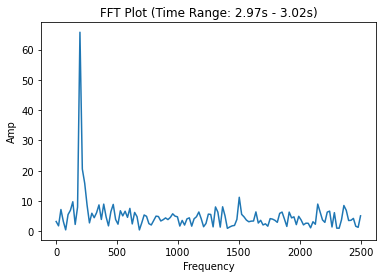

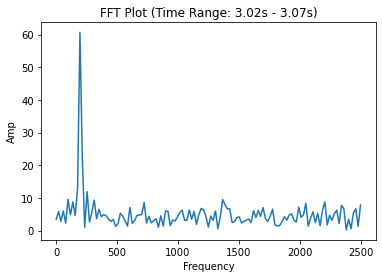

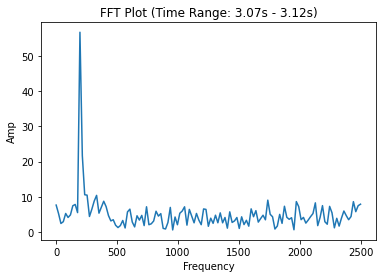

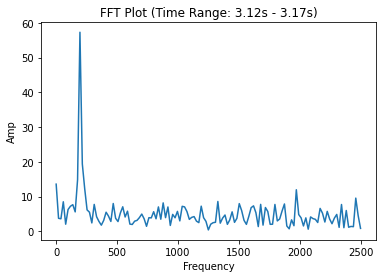

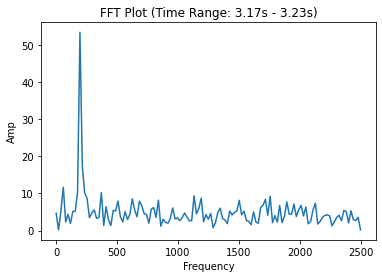

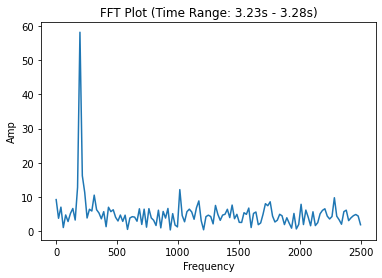

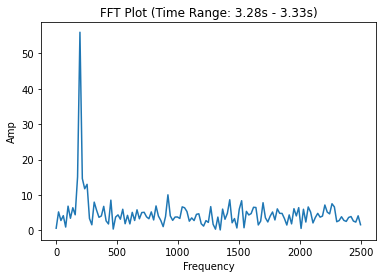

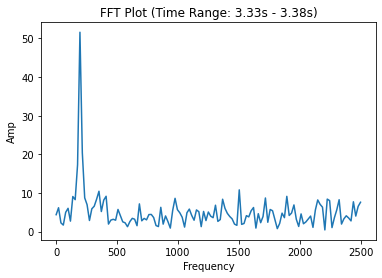

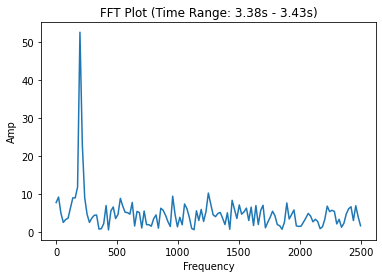

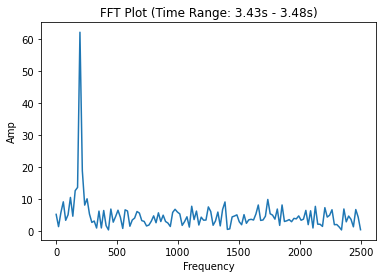

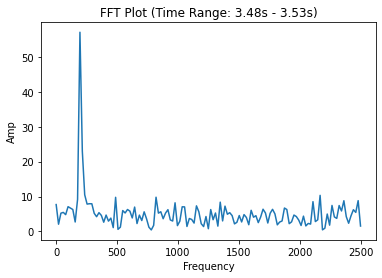

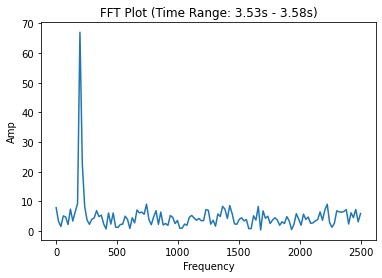

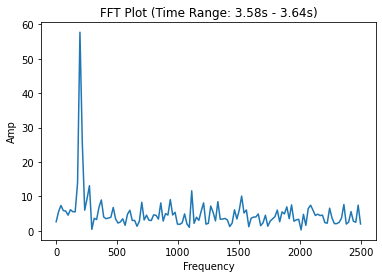

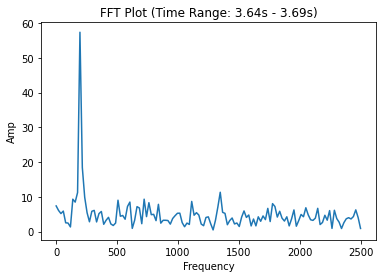

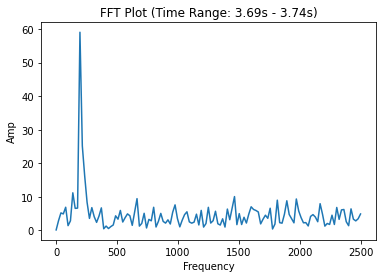

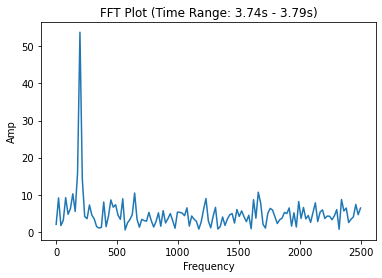

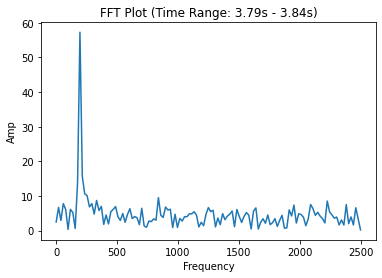

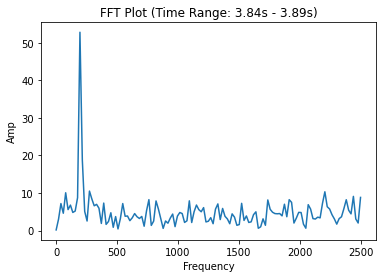

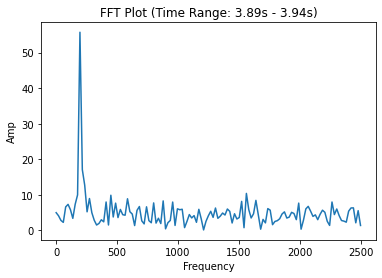

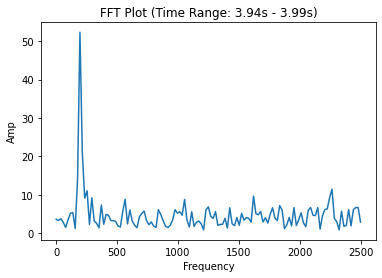

ValueError: x and y must have same first dimension, but have shapes (129,) and (17,)

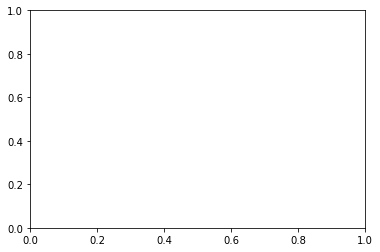

In [9]:
f = 200
sr = 5000
t = np.arange(0,2,1/sr)

noiz = 2*np.random.rand(len(t)) -1 
x= np.sin(2*np.pi*f*t)

signal = np.append(noiz, (noiz+x)*1/2)

window = 256

for i in range(0,len(signal),window):
    st = i
    en = i+window

    signalFrm = signal[st:en]

    fft = np.fft.rfft(signalFrm)
    freq = np.fft.rfftfreq(window, 1/sr)
    plt.plot(freq,np.abs(fft))
    plt.xlabel("Frequency")
    plt.ylabel("Amp")

    startTime = st / sr
    endTime = en /sr
    plt.title(f"FFT Plot (Time Range: {startTime:.2f}s - {endTime:.2f}s)") 
    plt.show()

